In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
%pip install kneed


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
data_file = "/Users/manitk/Desktop/SEM_V/ML_Project/Datasets/DeepTriage/classifier_data_0.csv"
df = pd.read_csv(data_file)
# taking only bug description
df = df.dropna(subset=['description']).drop_duplicates(subset=['description'])
X = df['description']
print("Number of Samples: ", len(X))
print("Number of Samples in DF: ", len(df))

Number of Samples:  116371
Number of Samples in DF:  116371


In [4]:
# PREPROCESSING
def preprocess_text(description):
    tokens = word_tokenize(description)
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

print("First Sample Before Preprocessing:", X.iloc[0])
X = X.apply(preprocess_text)
print("First Sample After Preprocessing:", X.iloc[0])

# remove words like - chrome, chromium, mozilla, firefox, google
X = X.str.replace('chrome', '')
X = X.str.replace('chromium', '')
X = X.str.replace('mozilla', '')
X = X.str.replace('firefox', '')
X = X.str.replace('google', '')

# applying changes to df also 
df['description'] = X

First Sample Before Preprocessing: Product Version      : <see about:version>URLs (if applicable) :0.2.149.27Other browsers tested: Firefox / IEAdd OK or FAIL after other browsers where you have tested this issue:Safari 3:    Firefox 3: OK         IE 7:OKWhat steps will reproduce the problem?1. Open any webpage on compaq 6715s running vista.2. Try scrolling with the touchpad3. Scrolling down will work , but up will not.What is the expected result?The page to scroll up.What happens instead?The page doesn't move.Please provide any additional information below. Attach a screenshot if possible.Only a minor bug. 
First Sample After Preprocessing: product version see version url applicable browser tested firefox ieadd ok fail browser tested issue safari firefox ok ie okwhat step reproduce problem open webpage compaq running try scrolling scrolling work expected result page scroll happens instead page provide additional information attach screenshot minor bug


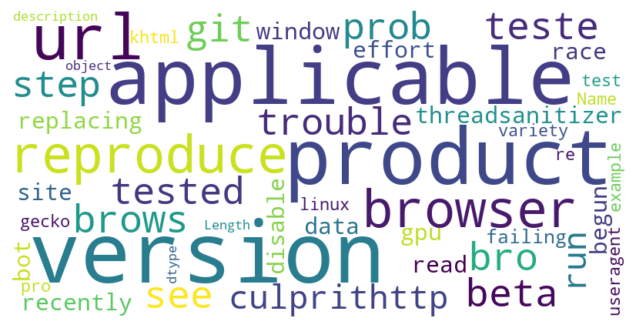

In [5]:
def create_word_cloud(X):
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(str(X))
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

create_word_cloud(X)

In [6]:
# TFIFD Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=5)
X = vectorizer.fit_transform(X)
print("Shape of X after TFIDF Vectorization: ", X.shape)

Shape of X after TFIDF Vectorization:  (116371, 5000)


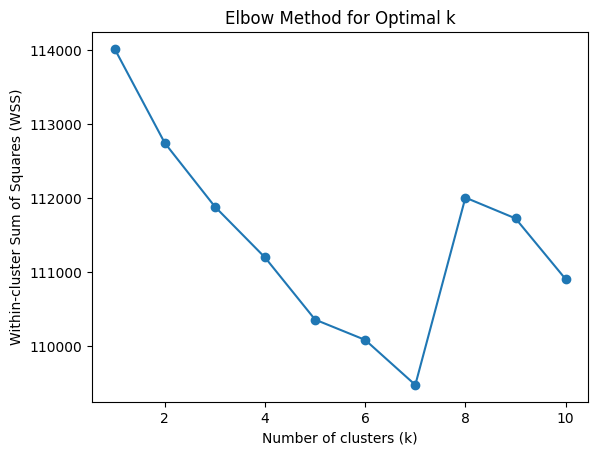

Optimal Value of k:  7
Number of Samples in each Cluster: 
cluster
0    78297
6    13044
3     9741
1     6395
2     3769
5     2588
4     2537
Name: count, dtype: int64


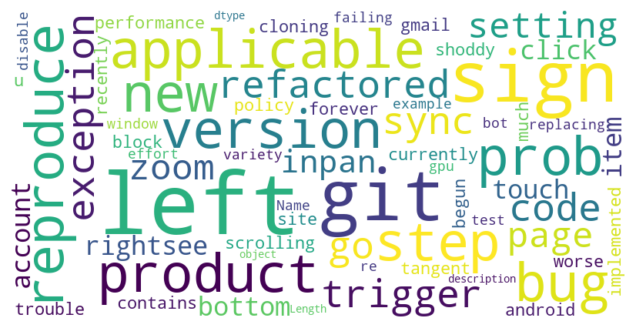

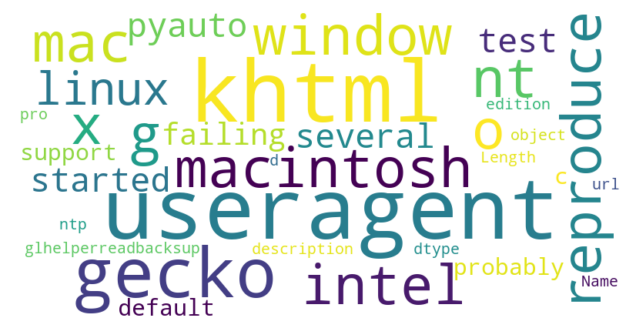

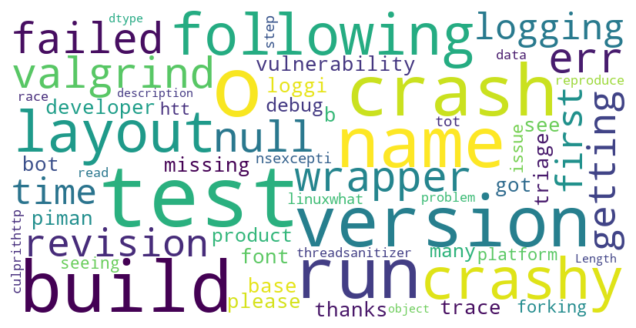

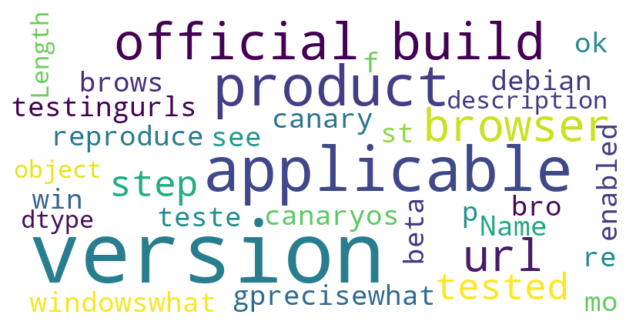

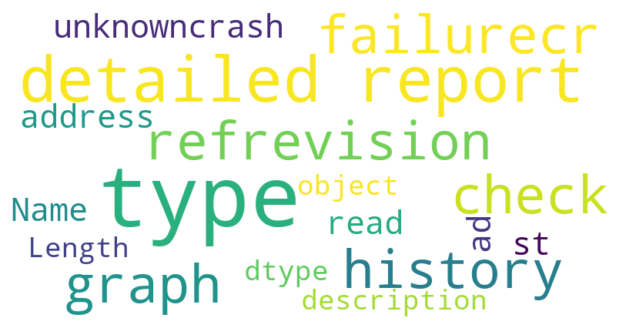

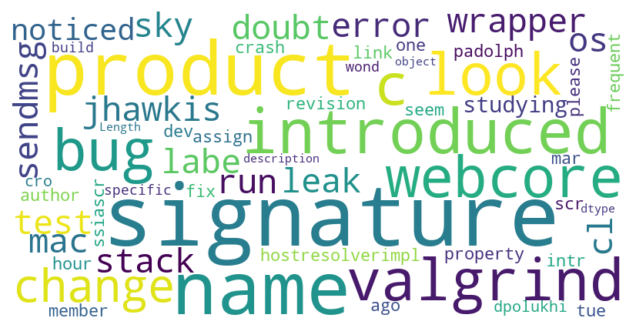

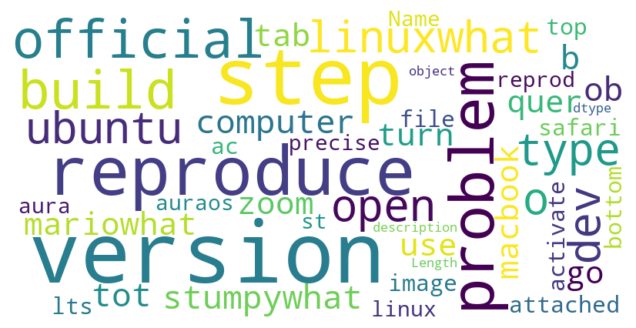

In [7]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

wss = []
k = 10
for k in range(1,k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

plt.plot(range(1,k+1), wss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.show()

kl = KneeLocator(range(1,k+1), wss, curve='convex', direction='decreasing')
print("Optimal Value of k: ", kl.elbow)

# KMeans Clustering
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_

print("Number of Samples in each Cluster: ")
print(df['cluster'].value_counts())

# word cloud for each cluster
for cluster in range(kl.elbow):
    cluster_data = df[df['cluster'] == cluster]
    cluster_description = cluster_data['description']
    create_word_cloud(cluster_description)

Number of Samples in each Cluster: 
cluster
5    6786
3    1641
4     854
2     790
6     788
1     584
0     194
Name: count, dtype: int64


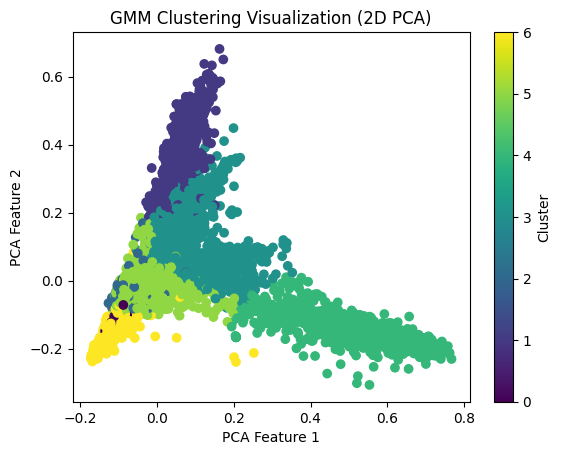

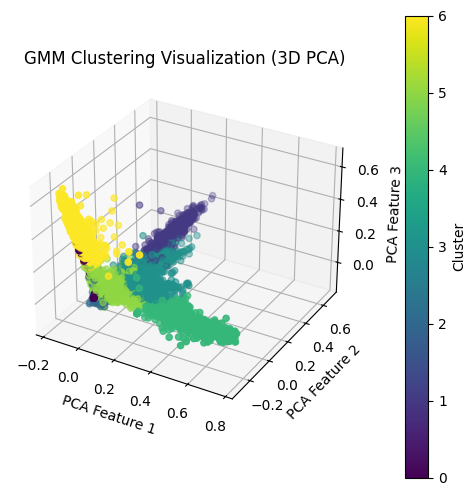

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# trying GMM on first 1% of samples randomly
samples = int(0.1 * X.shape[0])
tmp = df.sample(samples, random_state=42)

# GMM Clustering
gmm = GaussianMixture(n_components=7, random_state=42)
gmm.fit(X[:samples].toarray())
tmp['cluster'] = gmm.predict(X[:samples].toarray())

print("Number of Samples in each Cluster: ")
print(tmp['cluster'].value_counts())

# 2 Dimensional PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X[:samples].toarray())

plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=tmp['cluster'], cmap='viridis', marker='o')
plt.title("GMM Clustering Visualization (2D PCA)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.colorbar(label="Cluster")
plt.show()

# 3 Dimensional PCA
pca_3d = PCA(n_components=3)
reduced_X_3d = pca_3d.fit_transform(X[:samples].toarray())

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_X_3d[:, 0], reduced_X_3d[:, 1], reduced_X_3d[:, 2], c=tmp['cluster'], cmap='viridis', marker='o')

ax.set_title("GMM Clustering Visualization (3D PCA)")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_zlabel("PCA Feature 3")

cbar = plt.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label("Cluster")
plt.show()


Number of Samples in each Cluster: 
cluster
1    13202
4     8341
6     2084
0     2024
3     1508
5     1187
2      746
Name: count, dtype: int64


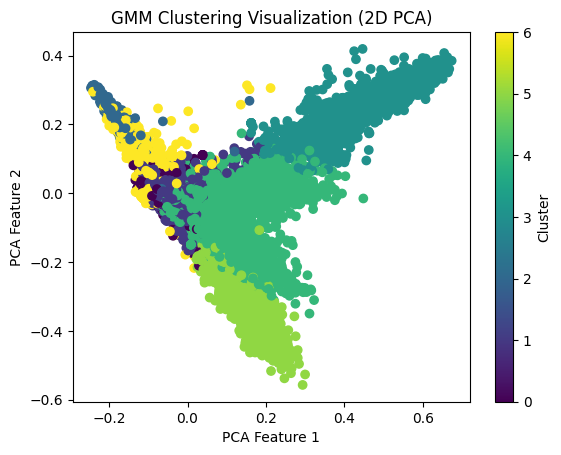

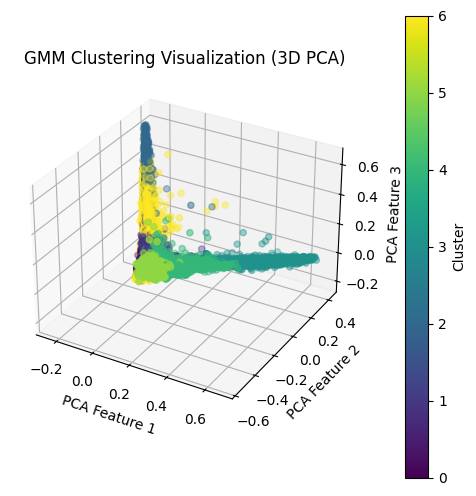

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# trying GMM on first 1% of samples randomly
samples = int(0.25 * X.shape[0])
tmp = df.sample(samples, random_state=42)

# GMM Clustering
gmm = GaussianMixture(n_components=7, random_state=42)
gmm.fit(X[:samples].toarray())
tmp['cluster'] = gmm.predict(X[:samples].toarray())

print("Number of Samples in each Cluster: ")
print(tmp['cluster'].value_counts())

# 2 Dimensional PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X[:samples].toarray())

plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=tmp['cluster'], cmap='viridis', marker='o')
plt.title("GMM Clustering Visualization (2D PCA)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.colorbar(label="Cluster")
plt.show()

# 3 Dimensional PCA
pca_3d = PCA(n_components=3)
reduced_X_3d = pca_3d.fit_transform(X[:samples].toarray())

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_X_3d[:, 0], reduced_X_3d[:, 1], reduced_X_3d[:, 2], c=tmp['cluster'], cmap='viridis', marker='o')

ax.set_title("GMM Clustering Visualization (3D PCA)")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_zlabel("PCA Feature 3")

cbar = plt.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label("Cluster")
plt.show()


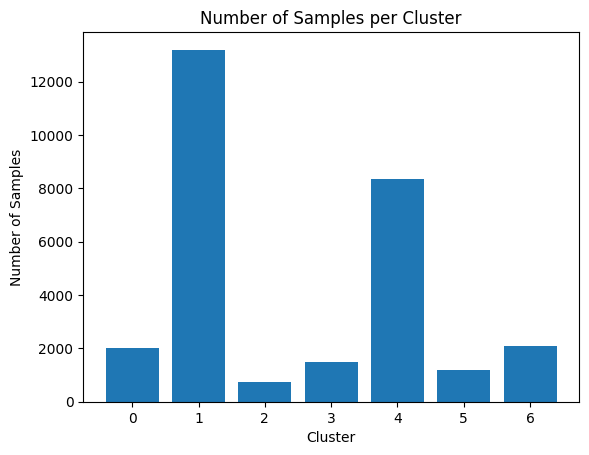

In [25]:
samples_per_cluster = [13202,8341,2084,2024,1508,1187,746]
clusters_lst = [1,4,6,0,3,5,2]
plt.bar(clusters_lst, samples_per_cluster)
plt.title("Number of Samples per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()
